In [1]:
!nvidia-smi

Wed Jul  9 23:25:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.19                 Driver Version: 561.19         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P5              8W /   20W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
import requests
import tempfile
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

ModuleNotFoundError: No module named 'pandas'

In [ ]:
# prompt: /content/dataset.zip extract

!unzip /content/dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Satellite Image data/cloudy/train_23598.jpg  
  inflating: dataset/Satellite Image data/cloudy/train_23608.jpg  
  inflating: dataset/Satellite Image data/cloudy/train_23634.jpg  
  inflating: dataset/Satellite Image data/cloudy/train_23636.jpg  
  inflating: dataset/Satellite Image data/cloudy/train_23646.jpg  
 extracting: dataset/Satellite Image data/cloudy/train_2366.jpg  
  inflating: dataset/Satellite Image data/cloudy/train_23664.jpg  
  inflating: dataset/Satellite Image data/cloudy/train_23706.jpg  
  inflating: dataset/Satellite Image data/cloudy/train_2380.jpg  
 extracting: dataset/Satellite Image data/cloudy/train_23805.jpg  
  inflating: dataset/Satellite Image data/cloudy/train_23806.jpg  
  inflating: dataset/Satellite Image data/cloudy/train_23826.jpg  
 extracting: dataset/Satellite Image data/cloudy/train_23843.jpg  
 extracting: dataset/Satellite Image data/cloudy/train_23877.jpg  
  inflating: 

In [ ]:
# Create an empty dataframe
data = pd.DataFrame(columns=['image_path', 'label'])

# Define the labels/classes

labels = {
    r"/content/dataset/Satellite Image data/cloudy": "Cloudy",
    r"/content/dataset/Satellite Image data/desert": "Desert",
    r"/content/dataset/Satellite Image data/green_area": "Green_Area",
    r"/content/dataset/Satellite Image data/water": "Water",
}

# Validate folder paths
for folder in labels:
    if not os.path.exists(folder):
        print(f"Warning: The folder {folder} does not exist.")
        continue

    # Process each image in the folder
    for image_name in os.listdir(folder):
        image_path = os.path.join(folder, image_name)
        if os.path.isfile(image_path):  # Only process files
            label = labels[folder]
            data = pd.concat([data, pd.DataFrame({'image_path': [image_path], 'label': [label]})], ignore_index=True)

# Display the resulting DataFrame
print(data)


                                             image_path   label
0     /content/dataset/Satellite Image data/cloudy/t...  Cloudy
1     /content/dataset/Satellite Image data/cloudy/t...  Cloudy
2     /content/dataset/Satellite Image data/cloudy/t...  Cloudy
3     /content/dataset/Satellite Image data/cloudy/t...  Cloudy
4     /content/dataset/Satellite Image data/cloudy/t...  Cloudy
...                                                 ...     ...
5624  /content/dataset/Satellite Image data/water/Se...   Water
5625  /content/dataset/Satellite Image data/water/Se...   Water
5626  /content/dataset/Satellite Image data/water/Se...   Water
5627  /content/dataset/Satellite Image data/water/Se...   Water
5628  /content/dataset/Satellite Image data/water/Se...   Water

[5629 rows x 2 columns]


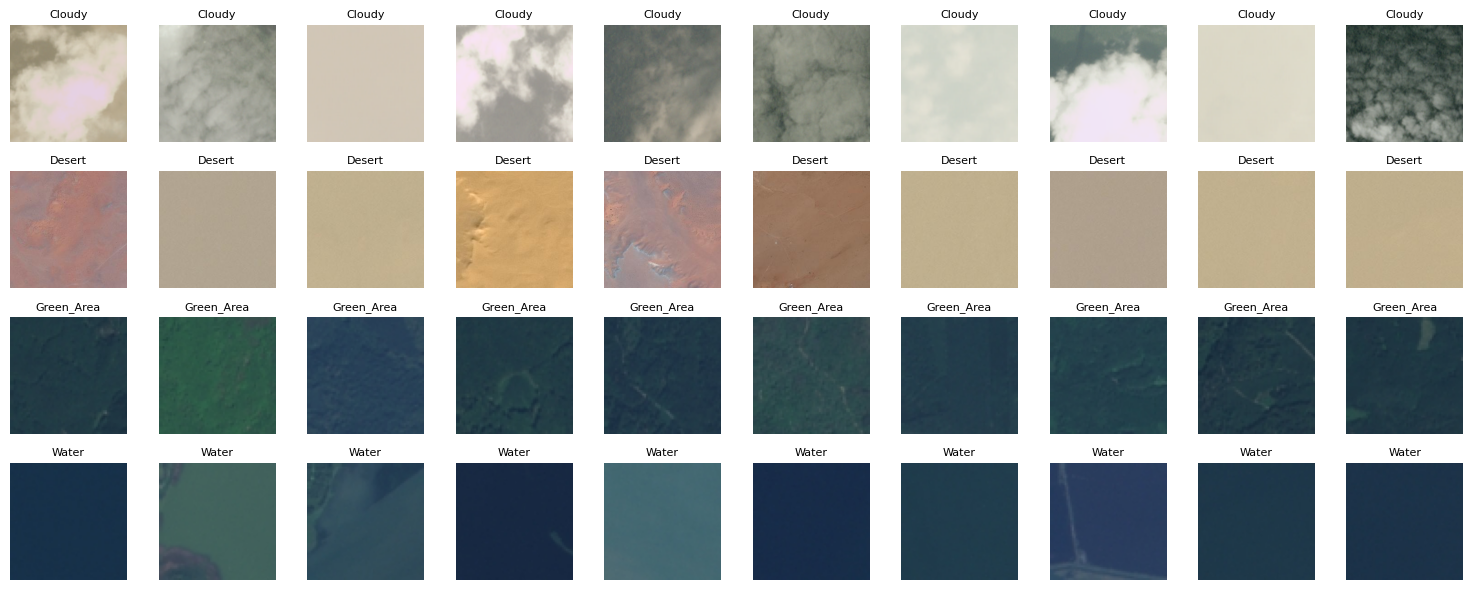

In [ ]:
# prompt: labels = {
#     r"/content/dataset/Satellite Image data/cloudy": "Cloudy",
#     r"/content/dataset/Satellite Image data/desert": "Desert",
#     r"/content/dataset/Satellite Image data/green_area": "Green_Area",
#     r"/content/dataset/Satellite Image data/water": "Water",
# } show sample 10 10 miages of all folder

fig, axes = plt.subplots(len(labels), 10, figsize=(15, len(labels) * 1.5))

for i, (folder, label_name) in enumerate(labels.items()):
    image_files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    sample_images = np.random.choice(image_files, min(10, len(image_files)), replace=False)

    for j, image_file in enumerate(sample_images):
        img_path = os.path.join(folder, image_file)
        try:
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].set_title(label_name, fontsize=8)
            axes[i, j].axis('off')
        except Exception as e:
            print(f"Error opening image {img_path}: {e}")
            axes[i, j].axis('off') # Turn off axis even if there's an error

for i in range(len(labels)):
    for j in range(len(sample_images), 10):
        axes[i, j].axis('off') # Turn off remaining axes if less than 10 images

plt.tight_layout()
plt.show()

In [ ]:
data.to_csv('image_dataset.csv', index=False)

In [ ]:
df = pd.read_csv("image_dataset.csv")

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=45,
                                   vertical_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    x_col="image_path",
                                                    y_col="label",
                                                    target_size=(255, 255),
                                                    batch_size=32,
                                                    class_mode="categorical")

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                  x_col="image_path",
                                                  y_col="label",
                                                  target_size=(255, 255),
                                                  batch_size=32,
                                                  class_mode="categorical")

Found 4503 validated image filenames belonging to 4 classes.
Found 1126 validated image filenames belonging to 4 classes.


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(255, 255, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 253, 253, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,492 (56.61 MB)

 Trainable params: 14,839,492 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_generator, epochs=25, validation_data=test_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
 68/141 ━━━━━━━━━━━━━━━━━━━━ 40s 556ms/step - accuracy: 0.5582 - loss: 0.9195

In [ ]:
num_samples = test_df.shape[0]
score = model.evaluate(test_generator, steps=num_samples//32+1)

In [ ]:
model.save('Modelenv.v1.h5')

In [ ]:
model = load_model("Modelenv.v1.h5")

In [ ]:
class_names = ['Cloudy', 'Desert', 'Green_Area', 'Water']

In [ ]:
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
predictions = model.predict(test_generator)
actual_labels = test_generator.classes
predicted_labels = np.argmax(predictions, axis=1)

In [ ]:
cm = confusion_matrix(actual_labels, predicted_labels)

In [ ]:
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes=class_names)
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()